In [1]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"

count = 0
# import data
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [4]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [35]:
df2 = df1.copy()

df2['duration'] = (df2['deadline'] - df2['created_at']) / np.timedelta64(1,'M')

num_months = round(max(df2['duration']))

# dictionary for all_projects
new_dict = {}
for i in range(num_months): # set up blank dictionary
    new_dict[i] = 0
for j in df2['duration']:
    if round(j) < num_months - 1: # round duration into number of months
        new_dict[round(j)] += 1
    else:
        new_dict[num_months - 1] += 1

In [36]:
# dictionary for successful projects

df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')
new_dict_success = {}

for i in range(num_months):
    new_dict_success[i] = 0
for j in df2_success['duration']:
    if round(j) < num_months - 1:
        new_dict_success[round(j)] += 1
    else:
        new_dict_success[num_months - 1] += 1

In [37]:
# dictionary for failed projects
df2_fail['duration'] = (df2_fail['deadline'] - df2_fail['created_at']) / np.timedelta64(1,'M')
new_dict_fail = {}

for i in range(num_months):
    new_dict_fail[i] = 0
for j in df2_fail['duration']:
    if round(j) < num_months - 1:
        new_dict_fail[round(j)] += 1
    else:
        new_dict_fail[num_months - 1] += 1

In [38]:
# dictionary for probability of success
new_dict_success_rate = {}

for i in new_dict.keys():
    if new_dict[i] > 10: # sufficient number of projects with that duration
        new_dict_success_rate[i] = new_dict_success[i] / new_dict[i]

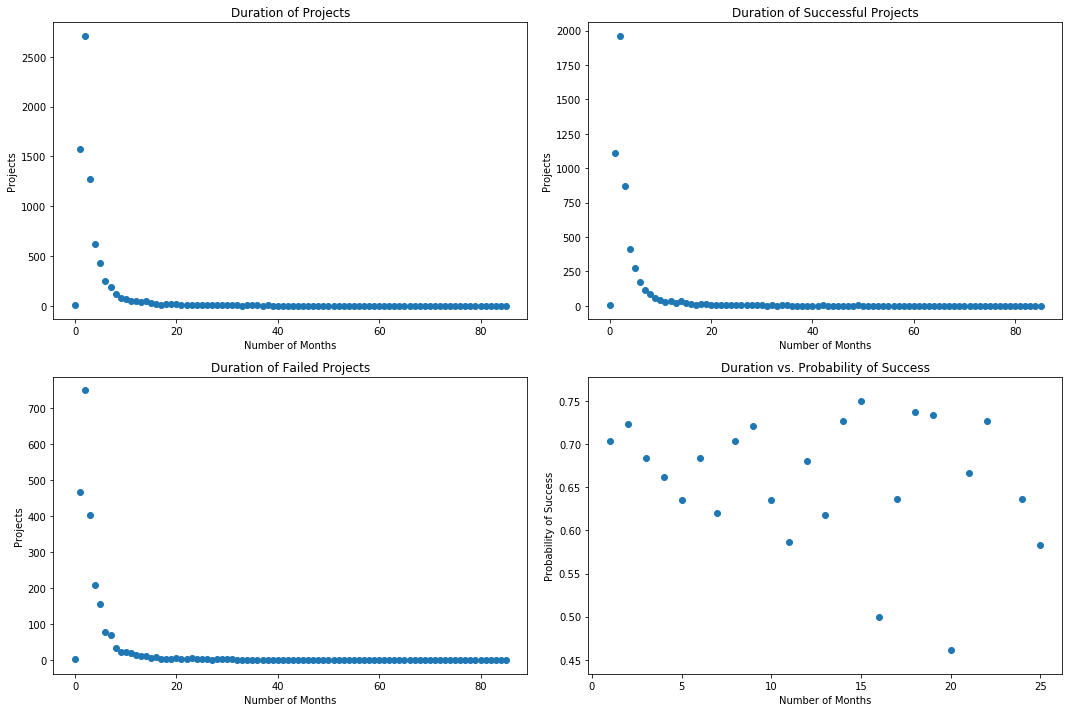

In [39]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(15, 10))

# PLOT DURATION VS NUMBER OF PROEJCTS
plt.subplot(2, 2, 1)
plt.scatter(new_dict.keys(),new_dict.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Projects')

# PLOT DURATION VS NUMBER OF SUCCESSFUL PROEJCTS
plt.subplot(2, 2, 2)
plt.scatter(new_dict_success.keys(),new_dict_success.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Successful Projects')

# PLOT DURATION VS NUMBER OF FAILED PROEJCTS
plt.subplot(2, 2, 3)
plt.scatter(new_dict_fail.keys(),new_dict_fail.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Failed Projects')

# PLOT DURATION VS SUCCESS RATE
plt.subplot(2, 2, 4)
plt.scatter(new_dict_success_rate.keys(),new_dict_success_rate.values())
plt.xlabel('Number of Months')
plt.ylabel('Probability of Success')
plt.title('Duration vs. Probability of Success')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_duration_number_success_fail_prob_success.png')